# Preliminary data analysis

Here we deal with the preliminary data analysis of the graph, Reddit data as well as event series.

### 1) Import packages

In [142]:
import os
from pathlib import Path
import bz2, pickle, json

from pprint import pprint 
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind, ttest_rel, shapiro, wilcoxon

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm
tqdm.pandas()

from collections import Counter, OrderedDict

import networkx as nx
from networkx.readwrite import json_graph
import netwulf as nw
import seaborn as sns

import plotly.express as px


In [2]:
def read_json_file(filename):
    with open(filename) as f:
        js_graph = json.load(f)
    return json_graph.node_link_graph(js_graph)

In [54]:
# define plotting function
def LogAndLinearHist(data, xlabel='', figsize=((8,3)), dpi=100):
    min_val, max_val = (min(data), max(data))
    
    # compute bins
    log_bins = np.logspace(min_val if min_val == 0 else np.log10(min_val), np.log10(max_val), 21)
    lin_bins = np.linspace(min_val, max_val, 101)

    # create histogram values
    hist_log, edges_log = np.histogram(data.values, log_bins, density=True)
    hist_lin, edges_lin = np.histogram(data.values, lin_bins)

    # determine x-values
    log_x = (edges_log[1:] + edges_log[:-1]) / 2.
    lin_x = (edges_lin[1:] + edges_lin[:-1]) / 2.

    xx, yy = zip(*[(i,j) for (i,j) in zip(log_x, hist_log) if j > 0])
    
    # plot figure
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize, dpi=dpi)

    # linear scale plot
    ax[0].plot(lin_x, hist_lin, marker='.', alpha=0.5)
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel('count')
    ax[0].set_title('linear scale')
    #ax[0].legend()

    # log-log scale plot
    ax[1].plot(xx, yy, marker='.', alpha=0.5)
    ax[1].set_yscale('log')
    ax[1].set_xscale('log')
    ax[1].set_xlabel(xlabel)
    ax[1].set_ylabel('probability density')
    ax[1].set_title('log-log scale')
    #ax[1].legend()

    # show figure
    plt.tight_layout()
    plt.show()

In [68]:
from plotly.subplots import make_subplots

def make_subplots_from_px(figs, title, unified_hover=True):
    fig_traces = [[], [], []]
       
    for i, fig in enumerate(figs):
        for trace in range(len(fig["data"])):
            fig_traces[i].append(fig["data"][trace])   

    fig = make_subplots(rows=len(figs), cols=1)

    for i in range(len(figs)):
        for traces in fig_traces[i]:
            fig.append_trace(traces, row=i+1, col=1)  

    if unified_hover:    
        fig.update_layout(hovermode="x unified")    
        
    fig.update_traces(xaxis='x1')
    
    # Making sure classes only show up once in legend
    names = set()
    fig.for_each_trace(lambda trace: trace.update(showlegend=False) if (trace.name in names) else names.add(trace.name))
    
    fig.update_layout(height=600, width=800, title_text=title)
    return fig

In [3]:
DATA_DIR = Path(os.getcwd()) / 'data'

### 2) Climate Change Opinion classifier

The classifier was a RandomForest classifier trained on the annotated Twitter data (as described in the explainer notebook) and optimized with randomized search and cross-validation for 500 different parameter combinations within the parameter grid described below.

```
parameters = {'clf__n_estimators': [800, 1000, 1200, 1400, 1600, 1800, 2000],
               'clf__max_features': ['sqrt', 'auto'],
               'clf__max_depth': [90, 100, 110, 120, 130, 140],
               'clf__min_samples_split': [2, 4, 6, 8, 10],
               'clf__min_samples_leaf': [1, 2, 3, 4],
               'clf__bootstrap': [False, True]}
```

All steps containing a stochastic element were carried out using `random_state=42`. 

The Climate Change opinion classifier training step is implemented in the file `exploration/opinion_classifier.py`. This section describes the training of the classifier and evaluates its performance. First, data was loaded.

In [4]:
filename = 'twitter_sentiment_data.csv'
tweets = pd.read_csv(DATA_DIR/filename)

# map opinion label
class_mapping = {2: 'News',
                 1: 'Pro',
                 0: 'Neutral',
                 -1: 'Anti'}

tweets['label'] = tweets['sentiment'].progress_apply(lambda x: class_mapping[x])

tweets.head()

  0%|          | 0/43943 [00:00<?, ?it/s]

,sentiment,message,tweetid,label
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840,Anti
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641,Pro
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256,Pro
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904,Pro
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153,News


In [5]:
print(f"Number of data points: {tweets.__len__()}")

Number of data points: 43943


Before training the classifier it is important to investigate the label distribution. This can be seen in the following pie chart, created in the file `exploration/opinion_classifier.ipynb`.

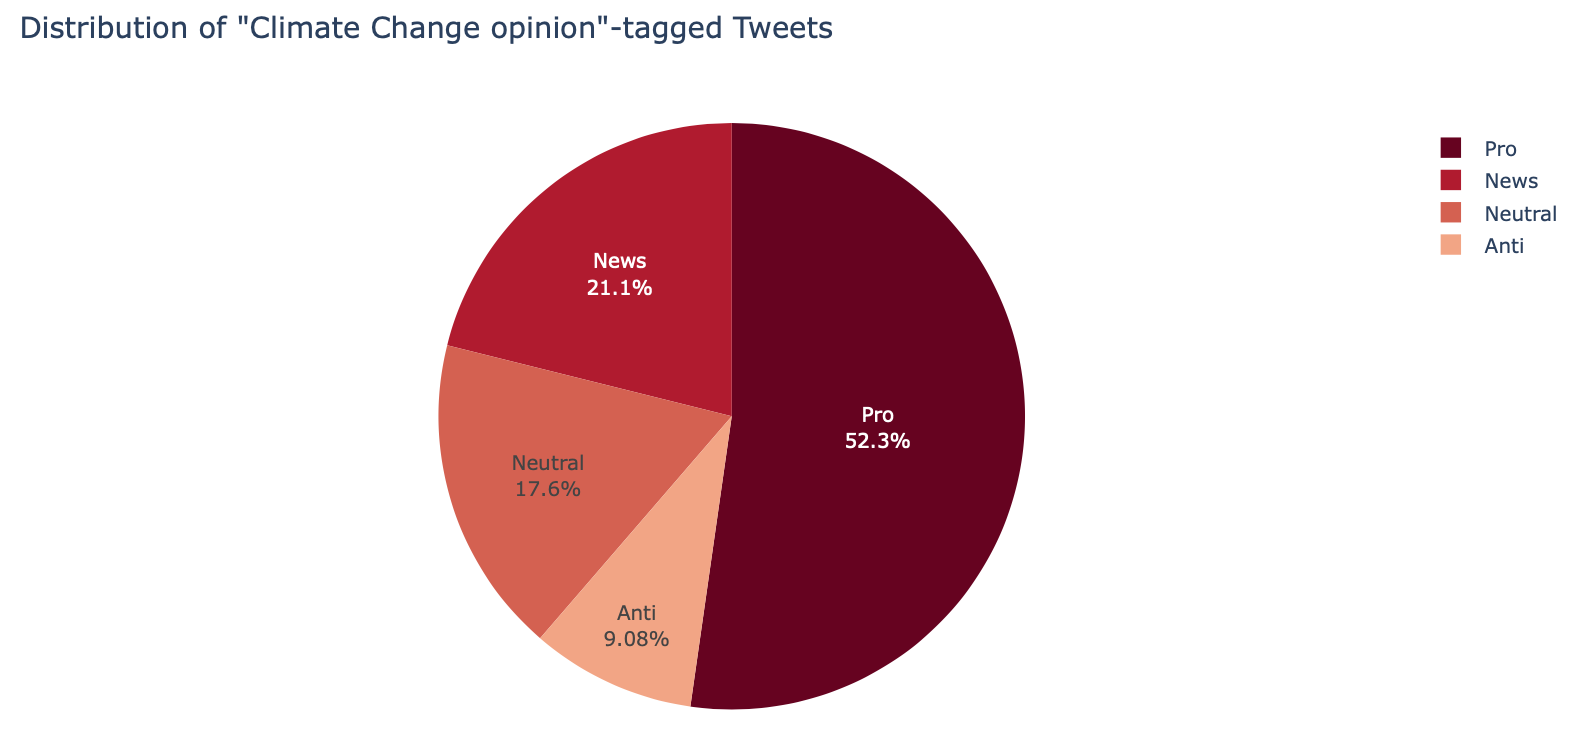

Here, it is evident that the 'Pro' class is the largest one that is approximately 6 times larger than the smallest class, 'Anti'. In order to not train a biased model, we decided to downsample all classes to the size of the smallest class, 'Anti'.

In [6]:
# define smallest group
smallest_group = tweets[tweets['label'] == 'Anti']
smallest_group_size = smallest_group.__len__()

# downsample each class to the size of the smallest group
temp = [smallest_group]
for label in class_mapping.values():
    if label != 'Anti':
        temp.append(tweets[tweets['label'] == label].sample(smallest_group_size, random_state=42))
        
# create balanced dataset
tweets_balanced = pd.concat(temp)

# shuffle and reindex the data
tweets_balanced = tweets_balanced.sample(frac=1, random_state=42)
tweets_balanced = tweets_balanced.reset_index().drop('index', axis=1)
tweets_balanced.head()

,sentiment,message,tweetid,label
0,-1,"RT @TheMarkRomano: Remember, we're supposed be...",857188789726433281,Anti
1,2,RT @RiceRPLP: Religion plays a bigger role in ...,809918715999289344,News
2,2,Climate change is a major global challenge: PM...,671369836635758593,News
3,1,RT @DrJillStein: Trump pretends not to believe...,793490890102714369,Pro
4,0,I love when republicans talk about climate change,644342836389810176,Neutral


Next, the tweets were processed using the standard pre-processing pipeline, meaning that the text was tokenized into words, lower-cased after which stop-words and non-alphabetical characters were excluded. Furthermore, stemming was applied and the Twitter-specific token "RT" was removed since the classifier later on should be used for predicting opinion scores on Reddit data.

In [7]:
# load stop-words
stop_words = set(stopwords.words('english'))

# add webpages to stopwords
stop_words.add('http') 
stop_words.add('https')

porter = PorterStemmer()

exclusions = {'RT'}

# define tokenizing function
clean = lambda x: set([porter.stem(word_token).lower() for word_token in word_tokenize(x) \
                       if word_token.lower() not in stop_words \
                       and word_token.isalpha() \
                       and word_token not in exclusions])

# apply tokenizing to texts - progress_apply for seeing progress bar WHEN running
tokens = tweets_balanced['message'].progress_apply(lambda text: clean(text))
tweets_balanced['tokens'] = tokens

  0%|          | 0/15960 [00:00<?, ?it/s]

The processing created a token-representation for a text. These were once again concatenated, to fit in line with the classifier training step. A training size of 70% of the total data was chosen.

The actual classifier was implemented using the sklearn `Pipeline` method where a Twitter text was mapped to a Bag-of-Word representation (using `CountVectorizer`) after which TF-IDF scores were computed (using `TfidfTransformer`) and fed to the `RandomForestClassifier`. This is seen here:

```
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(criterion='gini', random_state=42))
])
```

In [8]:
tweets_balanced['processed_message'] = tweets_balanced['tokens'].progress_apply(lambda x: (" ").join(x))
tweets_balanced['processed_message'].to_numpy()

X = tweets_balanced['processed_message'].to_numpy()
y = tweets_balanced['label'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

  0%|          | 0/15960 [00:00<?, ?it/s]

The training procedure was carried out on DTU GBAR due for computational reasons. The final model was pickled and is now loaded and evaluated.

In [9]:
pkl_filename = DATA_DIR.parent / 'model/RandomForest_TwitterOpinion500_iter.pkl'

with open(pkl_filename, 'rb') as file:
    model = pickle.load(file)

Evaluating the classifier on the balanced accuracy score yields a balanced accuracy of 0.605.

In [29]:
predicted = model.predict(X_test)
print("Balanced Accuracy on Test Data: ", balanced_accuracy_score(y_test, predicted))

Balanced Accuracy on Test Data:  0.6072449906909625


Even though the model was optimized, this is not super high and will probably influence the conclusion that can be drawn in these analyses. However, looking at the confusion matrix (and it's normalized version) below, it becomes evident that the classifier is overall getting the trend. 

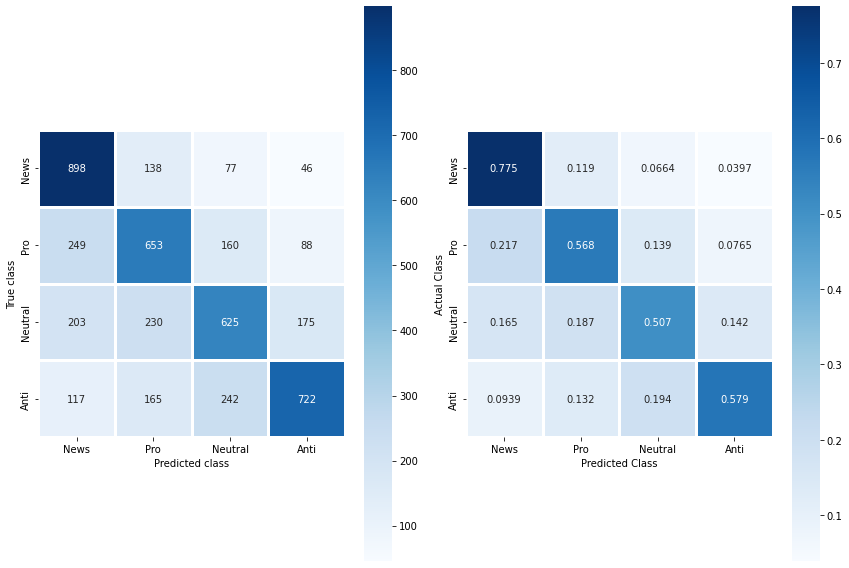

In [27]:
label_order = np.array(list(class_mapping.values()))
cm = confusion_matrix(y_test, predicted, labels=label_order)

plt.figure(figsize=((12,8)))

plt.subplot(121)
sns.heatmap(cm, annot=True, fmt='g', linewidths=3, cmap='Blues', square=True, xticklabels=label_order, yticklabels=label_order)
plt.xlabel('Predicted class')
plt.ylabel('True class')

label_order = np.array(list(class_mapping.values()))
cm = confusion_matrix(y_test, predicted, labels=label_order, normalize='true')

plt.subplot(122)
sns.heatmap(cm, annot=True, fmt='.3g', linewidths=3, cmap='Blues', square=True, xticklabels=label_order, yticklabels=label_order)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')

plt.tight_layout()
plt.show()

It is seen that the classification error is mostly occurring on the classes 'Pro' and 'Neutral'. The 'News' class is the most distinguishable one which might be due to the somewhat different oultine of news articles compared to regular tweets. What can further be seen in the confusion matrix, is that the classifier quite rarely confuse the 'Pro'-class with the 'Anit'-class but that there oppositely are cases were 'Anti' climate change is confused with 'Pro', which might be due to sarcasm or other ambiguous-related tendencies. This trend is worth having in mind through further analyses as it might result in more 'Pro'-predictions than 'Anti'-predictions.

However, the 'Pro'-class is quite frequently confused with 'News' or 'Neutral', which might bias the findings in the project, as both 'News' and 'Neutral' are mapped as "0" in opinion score. Since this is not the case for the 'Anti'-class, the findings in the research questions might suggest that opinion about climate change is lower than what is actually the case.

In [31]:
print(classification_report(y_test, predicted, digits=3))

              precision    recall  f1-score   support

        Anti      0.700     0.579     0.634      1246
     Neutral      0.566     0.507     0.535      1233
        News      0.612     0.775     0.684      1159
         Pro      0.551     0.568     0.559      1150

    accuracy                          0.605      4788
   macro avg      0.607     0.607     0.603      4788
weighted avg      0.608     0.605     0.603      4788



### 3) Reddit submission and comments

Since the project is based on Reddit, this section briefly summarizes key-points about the comments and submissions data. More elaborate findings are mentioned later on in the graph version of the Reddit-ClimateGraph and even more elaborate analyses are provided in the notebooks `RQ1`, `RQ2` and `RQ3`.

In [ ]:
start = time.time()

# load data
comments = pd.read_json(DATA_DIR / f'comments90k_opinion.json.bz2')
submissions = pd.read_json(DATA_DIR / f'submissions_opinion.json.bz2')

end = time.time()
print(f"Took {end-start} seconds to load dataframe...")

Since the data is extracted in the period between 2014 and 2022, there are quite a high amount of submissions, namely more than xxx submissions. The comments were subtracted based on a sample of 90.000 of the submissions for computational reasons, but result in a total size of the dataframe of xxx comments.

In [ ]:
print(f"Number of submissions extracted: {submissions.__len__()}")
print(f"Number of comments extracted: {comments.__len__()}")

Through initial analysis it was found that certain data points of submissions and comments are uninformative, since the actual posts have been deleted. This is mapped in the dataset as `[deleted]`. These are removed, which changes the size of the data. The share of removed posts and submissions out of the total data is not critically high, as seen in the number below

In [ ]:
# filter submissions and remove rows with deleted users
filtered_submissions = submissions

deleted_users_idx = filtered_submissions.author == '[deleted]'
filtered_submissions = filtered_submissions[-deleted_users_idx]
print(f"Number of deleted users: {deleted_users_idx.sum()}")

# update index
filtered_submissions.reset_index(drop=True, inplace=True)
print(f"Shape of filtered submissions: {filtered_submissions.shape}")

In [144]:
# filter comments and remove rows with deleted users
filtered_comments = comments

deleted_users_idx = np.logical_or(filtered_comments.author == '[deleted]', filtered_comments.parent_author == '[deleted]')
filtered_comments = filtered_comments[-deleted_users_idx]
print(f"Number of deleted users: {deleted_users_idx.sum()}")

# update index
filtered_comments.reset_index(drop=True, inplace=True)
print(f"Shape of filtered comments: {filtered_comments.shape}")

Number of deleted users: 95383


(924944, 17)

### 4) Authors

Since the final graph is built on the set of Reddit authors, these are here briefly analysed. First, data is loaded.

In [70]:
authors = pd.DataFrame([])

for year in tqdm([2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]):
    temp = pd.read_json(DATA_DIR / f'{year}/author_opinion_{year}.json.bz2').reset_index().rename(columns={'index':'author'})
    temp['year'] = year
    authors = pd.concat([authors, temp])


  0%|          | 0/9 [00:00<?, ?it/s]

In [71]:
print(f"Number of unique authors across all years: {authors.author.unique().__len__()}")

Number of unique authors across all years: 345645


So in general there are quite a lot of authors but it is quite evident, when looking at the figure below, that their occurrence is not uniformly distributed across years. It is seen that the network of Reddit authors participating in the Climate Change debate is in general higher for the years 2019-2021 than before 2019. In 2022 the size of the network is lower, since data was only collected until April 2022.

In [65]:
temp = authors.groupby('year').size().reset_index().rename(columns={0: 'number of authors'})

fig_authors = px.bar(temp, x='year', y='number of authors')
fig_authors.show()

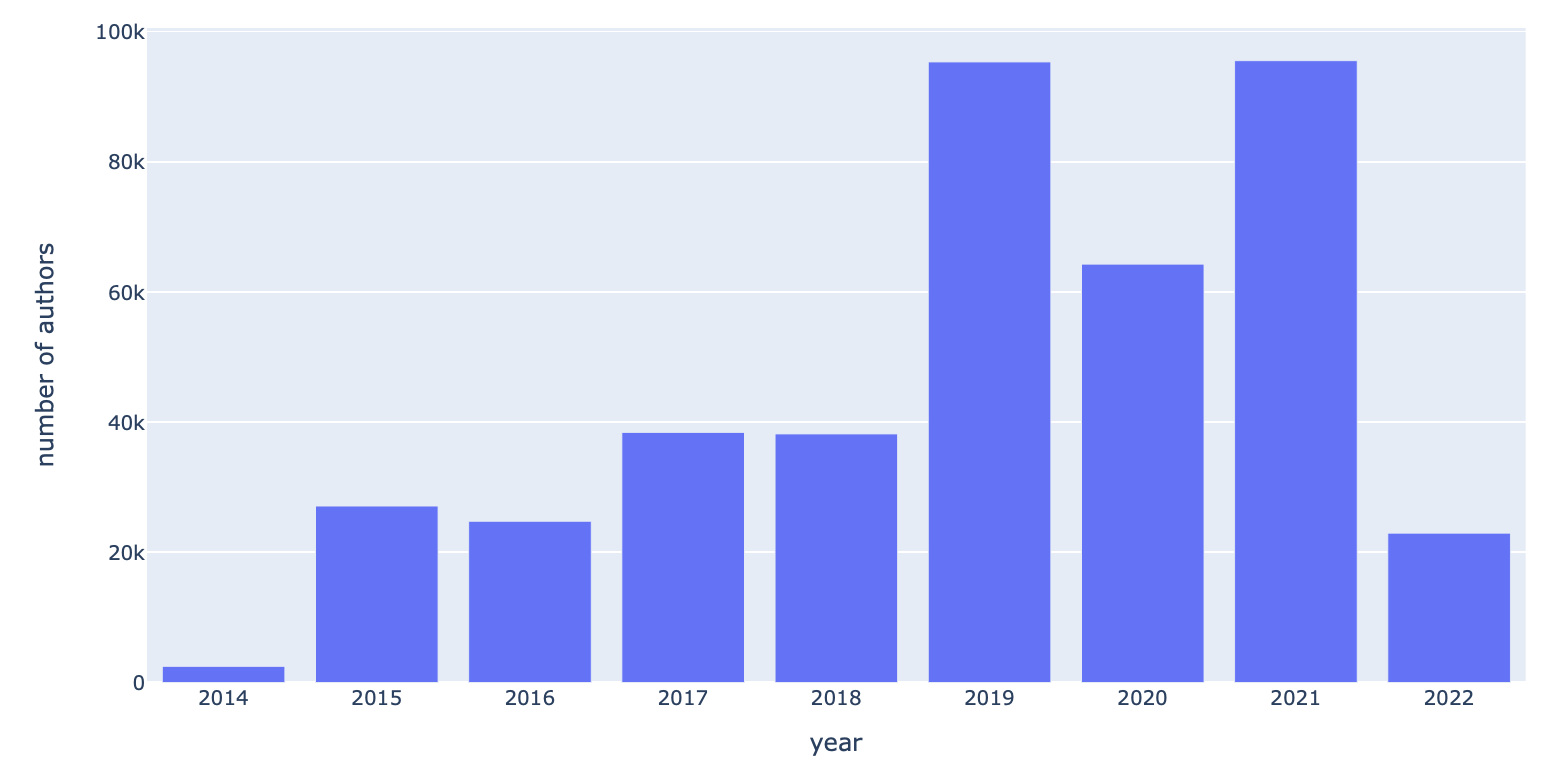

When investigating this temporal trend, it is further interesting to examine the lifespan of the authors: do Reddit authors continuously participate in the climate change debate and if so, for how long of a period?

The lifespan is visualized below and is defined by the difference between the first and last activity (either comments or submissions) in the climate change debate. The plot will be discussed below the visualization.

In [114]:
df_lifespan = pd.DataFrame([])

df_lifespan = pd.concat([df_lifespan, authors.groupby('author').first_comment.min()], axis=1)
df_lifespan = pd.concat([df_lifespan, authors.groupby('author').first_submission.min()], axis=1)

df_lifespan = pd.concat([df_lifespan, authors.groupby('author').last_comment.max()], axis=1)
df_lifespan = pd.concat([df_lifespan, authors.groupby('author').last_submission.max()], axis=1)

df_lifespan['_minTime_'] = df_lifespan.progress_apply(lambda x: min(x.first_comment, x.first_submission), axis=1)
df_lifespan['_maxTime_'] = df_lifespan.progress_apply(lambda x: max(x.last_comment, x.last_submission), axis=1)

  0%|          | 0/345645 [00:00<?, ?it/s]

  0%|          | 0/345645 [00:00<?, ?it/s]

In [116]:
from matplotlib.dates import date2num as d2n
from matplotlib.dates import DateFormatter
import matplotlib as mpl
import datetime

# bins with 7 days in between
min_bins = np.arange(min(df_lifespan._minTime_), max(df_lifespan._minTime_), step=3600*24*7)
max_bins = np.arange(min(df_lifespan._maxTime_), max(df_lifespan._maxTime_), step=3600*24*7)

# create histogram
hist2d, edges_x, edges_y = np.histogram2d(df_lifespan['_minTime_'], df_lifespan['_maxTime_'], bins=[min_bins, max_bins])

# format bins as dates
edges_x = [datetime.datetime.fromtimestamp(ts) for ts in edges_x]
edges_y = [datetime.datetime.fromtimestamp(ts) for ts in edges_y]
extent = [edges_x[0], edges_x[-1], edges_y[0], edges_y[-1]]
extent = d2n(extent)

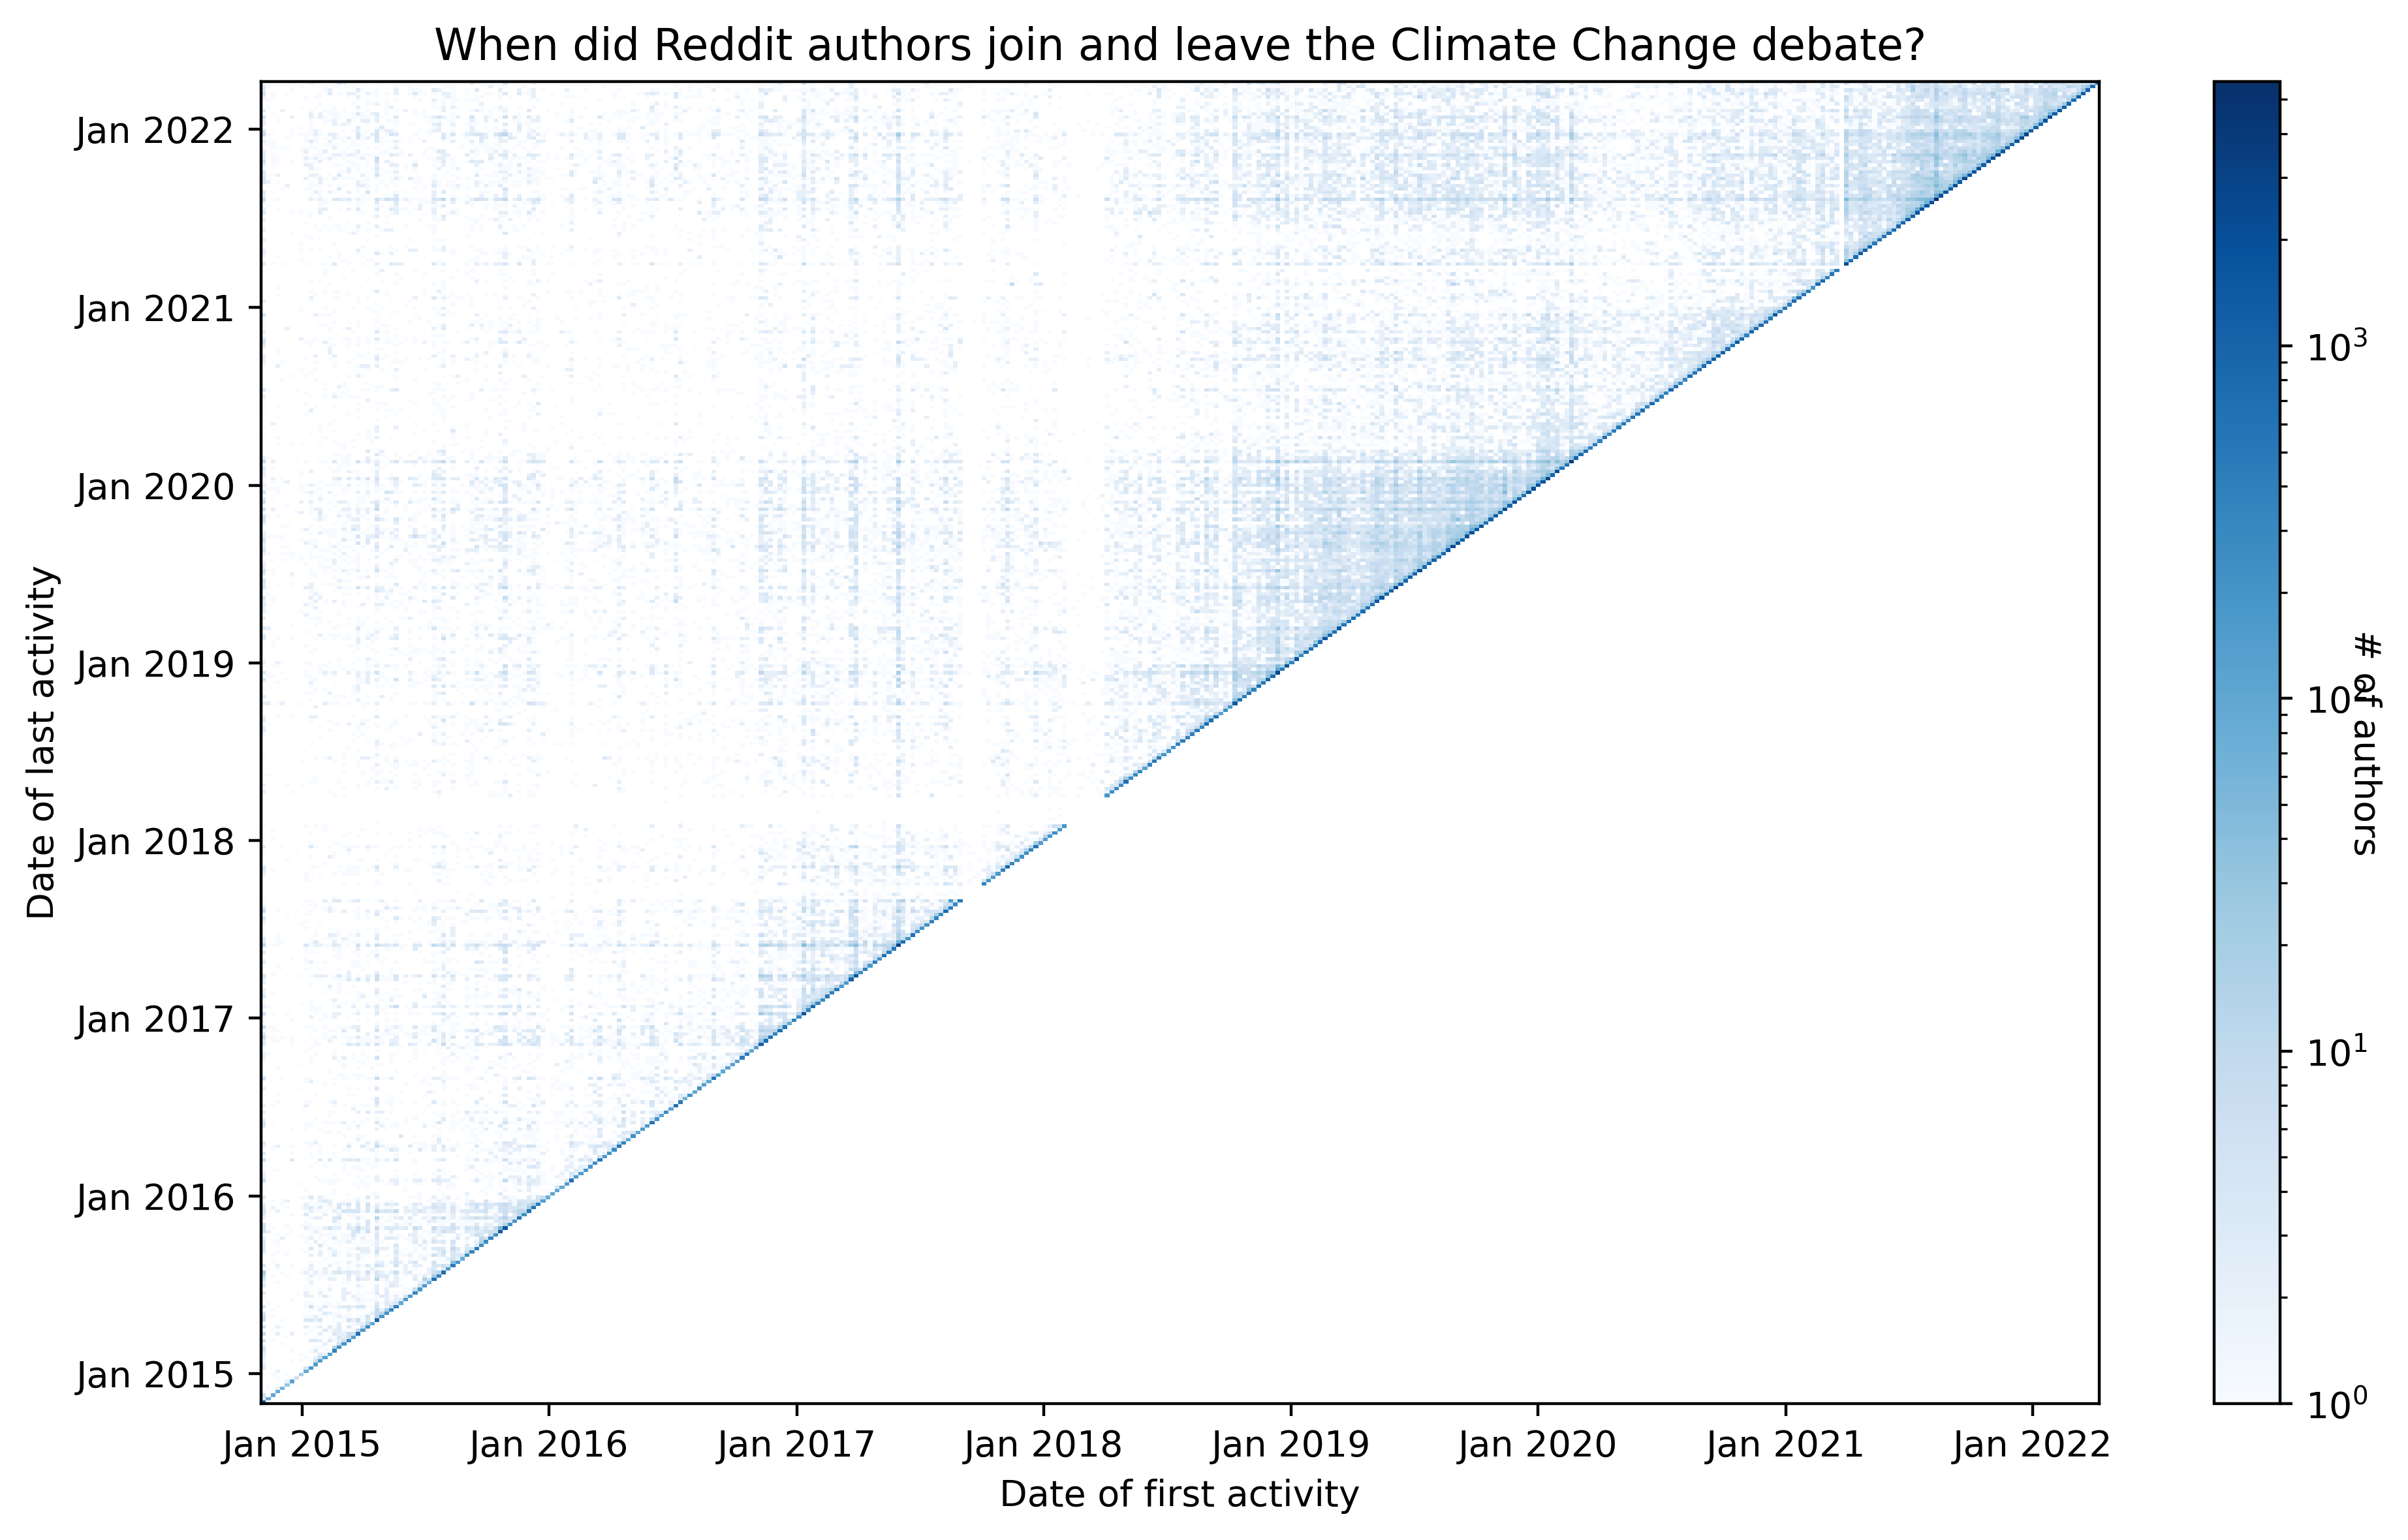

In [120]:
# plot figure
fig, ax = plt.subplots(figsize=((10,6)), dpi=400)
heatmap = ax.imshow(hist2d.T, extent=extent, origin='lower', cmap='Blues', norm=mpl.colors.LogNorm(), aspect='auto')

# add colorbar
cbar = fig.colorbar(heatmap, ax=ax)
cbar.ax.set_ylabel('# of authors', rotation=270)

# specify names, etc.
ax.set_title('When did Reddit authors join and leave the Climate Change debate?')
ax.set_xlabel('Date of first activity')
ax.set_ylabel('Date of last activity')

# Define the date format in plot
date_form = DateFormatter("%b %Y")
ax.xaxis.set_major_formatter(date_form)
ax.yaxis.set_major_formatter(date_form)
ax.xaxis_date()
ax.yaxis_date()

plt.tight_layout()
plt.show()

The lifespan plot reveals that many Reddit authors join and leave the discussion on the same date (or preceeding days), which is seen from the fact that there is a diagonal line of high value (colorscale). The lifespan plot is quite light in the first years which is due to the fact that there are much less authors for these years than for later years.

In the period between start 2020 and the mid of 2021, there are not as many authors joining the network as previously and preceedingly. Neither do people leave the discussion in a large scale in this range, but there is a trend for people who joined in the year before 2020-2021 to leave the discussion between mid 2021-2022. This could imply that the network was in general booming with submissions and posts where authors were super engaged in the discussion or indicate that there is another topic taking away the focus, such as the COVID-19 pandemic.

### 5) Natural Disasters dataset

This dataset, contains dates, countries, types, deaths and total number of affected people regarding each natural disaster, within the last 8 years. A period from the 1/1-2014, up until now, 1/5-2022.


In [128]:
# Reading natural disaster dataset
events = pd.read_csv(DATA_DIR / 'emdat.csv', sep=';', header=0)
events.head()

,Dis No,Year,Seq,Glide,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Disaster Subsubtype,Event Name,...,"Reconstruction Costs, Adjusted ('000 US$)",Insured Damages ('000 US$),"Insured Damages, Adjusted ('000 US$)",Total Damages ('000 US$),"Total Damages, Adjusted ('000 US$)",CPI,Adm Level,Admin1 Code,Admin2 Code,Geo Locations
0,2014-0532-BOL,2014,532,FL-2015-000008,Natural,Hydrological,Flood,Riverine flood,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"87,36629784",1,648;40443;40444;40445;40446;40447;40448;40449;...,NaN,"Beni, Chuquisaca, Cochabamba, La Paz, Oruro, P..."
1,2014-0292-CHN,2014,292,NaN,Natural,Meteorological,Storm,Convective storm,Severe storm,NaN,...,NaN,NaN,NaN,NaN,NaN,"87,36629784",2,NaN,13003,Name Unknown (Adm2).
2,2014-0227-CHN,2014,227,TC-2014-000092,Natural,Meteorological,Storm,Tropical cyclone,NaN,Typhoon Rammasun (Glenda),...,NaN,NaN,NaN,4232973.0,4845087.0,"87,36629784",1,903;904;906;929,NaN,"Guangdong Sheng, Guangxi Zhuangzu Zizhiqu, Hai..."
3,2014-0388-FRA,2014,388,NaN,Natural,Meteorological,Storm,Convective storm,Lightning/Thunderstorms,NaN,...,NaN,145000.0,165968.0,182000.0,208318.0,"87,36629784",2,NaN,16286;16287;16299;16327,"Ardeche, Aveyron, Gard, Herault (Adm2)."
4,2014-0183-GTM,2014,183,NaN,Natural,Meteorological,Storm,Tropical cyclone,NaN,Boris,...,NaN,NaN,NaN,NaN,NaN,"87,36629784",1,64832;64833;64834;64836;64837,NaN,"Alta Verapaz, Huehuetenango, Petén, Quiché, Sa..."


The dataset contains NaN values - the rows will be deleted if one of the columns of interest contains a NaN-value. One entry had an end-day of 31, in a month of only 30 days, which is regarded as an error. 

All in all 1477 rows are removed due to errorneuous data.

In [129]:
# At least one entry had end day 31, in a month of 30 days. 
# This is changed to NaN
events['End Day'] = events.apply(lambda x: np.nan if x['End Month'] in [2, 4, 6, 9, 11] and x['End Day'] >= 31 else x['End Day'], axis=1)

# Remove rows with NaNs in death-, affected- or any rows with date
before_drop = len(events)
events.dropna(subset=['Total Deaths', 'Total Affected', 'End Day', 'End Month', 'End Year', 'Start Day', 'Start Month', 'Start Year'], how='any', inplace=True)
print(f"{before_drop - len(events)} rows dropped cause of NaNs in either of ['Total Deaths', 'End Day', 'End Month', 'End Year', 'Start Day', 'Start Month', 'Start Year']")

# Creating start- and end-date columns from year-, month- and day- columns:
events['Start Date'] = events.apply(lambda x: str(int(x['Start Year']))+"-"+str(int(x['Start Month']))+"-"+str(int(x['Start Day'])), axis=1)
events['End Date'] = events.apply(lambda x: str(int(x['End Year']))+"-"+str(int(x['End Month']))+"-"+str(int(x['End Day'])), axis=1)

# Only using columns: 'Start Date', 'End Date' , 'Disaster Type', 'Continent', 'Total Deaths' and 'Total Affected'
events = events[['Start Date', 'End Date' , 'Disaster Type', 'Continent', 'Total Deaths', 'Total Affected']]

# Changing header to lower-case
events.columns = map(str.lower, events.columns)

1477 rows dropped cause of NaNs in either of ['Total Deaths', 'End Day', 'End Month', 'End Year', 'Start Day', 'Start Month', 'Start Year']


The dataset contains start- and end-dates for climate events. All rows are 'exploded', in order to have a row for each date within, said column. The 'total deaths' and 'total affected' will be averaged into each row. 

In [130]:
# 'Exploding' rows based on all dates within start- and end-date
dates = [pd.bdate_range(r[0],r[1]).to_series() for r in events[['start date','end date']].values]

# list containing number of extras we need of each row
lens = [len(x) for x in dates] 

# Creating rows
events = pd.DataFrame(
        {col:np.repeat(events[col].values, lens) for col in events.columns}
    ).assign(date=np.concatenate(dates))

# Instead of repating total deaths and total affected in each of said exploded rows, 
# we want the means: 

mean_deaths = []
mean_affected = []
count = 0

# Appnding means to lists
for num in lens:
    for i in range(num):
        mean_deaths.append(events.iloc[count]['total deaths'] / num)
        mean_affected.append(events.iloc[count]['total affected'] / num)        
        count += 1
        
# Adding columns to dataframe
events['mean deaths'] = mean_deaths
events['mean affected'] = mean_affected

# Removing total scores from dataframe
events = events[['date', 'disaster type', 'continent', 'mean deaths', 'mean affected']]

After exploding the columns the dataframe will have multiples of some days, since some disasters were overlapping. 
Therefore, the dataframe is grouped by day. The mean- deaths and affected will be summed in these instances, while the string-columns will be concatenated into lists. 

In [131]:
# Grouping by day - in order to fix overlapping disasters into single rows
# Values are summed, while strings are concatenated into lists
events = events.groupby(['date']).agg(lambda x : x.sum() if x.dtype=='float64' else ', '.join(x).split(", "))

For further analyses reasons, the dataframe is once again exploded based on the disaster type and continent. 

In [132]:
# Now exploding based on disaster type and continent, in order to have single points per disaster type on scatter plot
events = events.explode(['disaster type', 'continent'])

For now, the analysis is restricted to looking at the frequency of different disaster types. These are not balanced. Further examinations are provided in research question 1.

In [138]:
events.groupby('disaster type').size()

disaster type
Animal accident             1
Earthquake                 84
Epidemic                 7626
Extreme temperature       284
Flood                    6144
Glacial lake outburst       1
Landslide                 222
Mass movement (dry)         1
Storm                    1450
Volcanic activity          86
Wildfire                  612
dtype: int64

In [140]:
# save for future use
events.to_csv(DATA_DIR / 'emdat_processed.csv')

### 6) ClimateGraph

We start by loading the Reddit-ClimateGraph for the year 2020.

In [4]:
year = 2020
ClimateGraph = read_json_file(DATA_DIR / f'{year}/ClimateGraph_{year}.json')

Let's investigate some basic properties of the network, such as the size.

In [5]:
print(f"Number of nodes: {ClimateGraph.number_of_nodes()}")
print(f"Number of edges: {ClimateGraph.number_of_edges()}")

Number of nodes: 64260
Number of edges: 95736


As is seen in the figures below, the degree-distributions of this network is following a power law, meaning that many Reddit authors have low in- and out-reach, yet a small minority of the Reddit authors have respectively high in- and out-reach.

In [6]:
in_degree = pd.Series(np.array(list(zip(*ClimateGraph.in_degree())))[1].astype('int'))
out_degree = pd.Series(np.array(list(zip(*ClimateGraph.out_degree())))[1].astype('int'))
degree = pd.Series(np.array(list(zip(*ClimateGraph.degree())))[1].astype('int'))

df_degrees = pd.DataFrame([in_degree, out_degree, degree], index=['in-degree', 'out-degree', 'degree']).T
df_degrees.describe()

,in-degree,out-degree,degree
count,64260.000000,64260.000000,64260.000000
mean,1.489823,1.489823,2.979645
std,7.764975,3.350204,9.260341
min,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000
50%,1.000000,1.000000,2.000000
75%,1.000000,1.000000,3.000000
max,732.000000,604.000000,732.000000


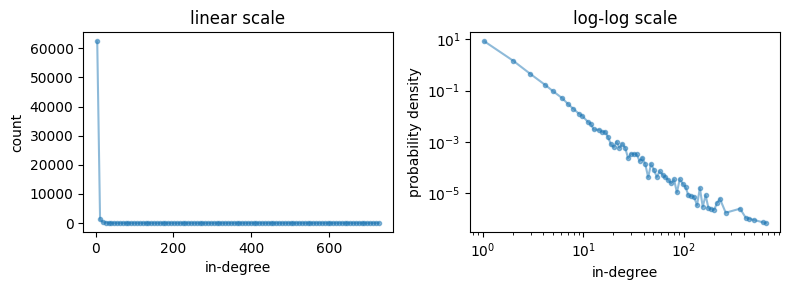

In [8]:
LogAndLinearHist(in_degree, xlabel='in-degree')

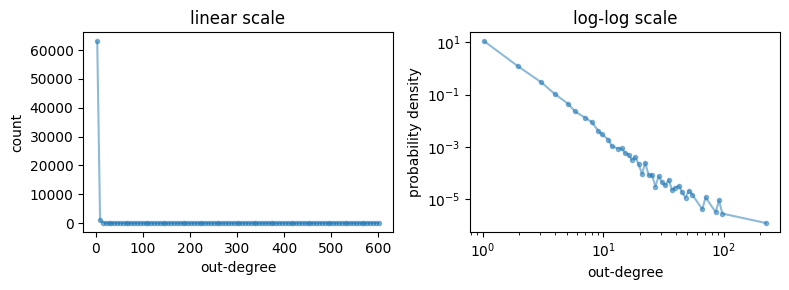

In [9]:
LogAndLinearHist(out_degree, xlabel='out-degree')

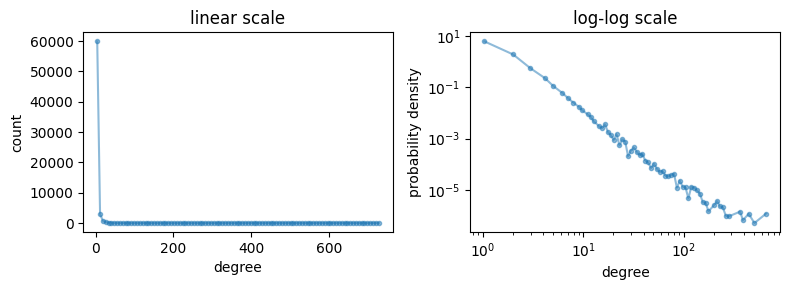

In [10]:
LogAndLinearHist(degree, xlabel='degree')

The power law distribution means that there, e.g., is only 98 Reddit authors that are referrenced to by more than 50 other Reddit authors.

In [58]:
print(f"Number of authors with in-degree above 50: {(in_degree > 50).sum()}")

Number of authors with in-degree above 50: 98


One of the key properties of the ClimateGraph is the associated opinion score. This score is individual for each author and was created as the average opinion across their respective comments and submissions to climate change within the year. This score distribution is key for decision-making related to the research questions.

The distribution of opinion scores is visualized in the plots below.

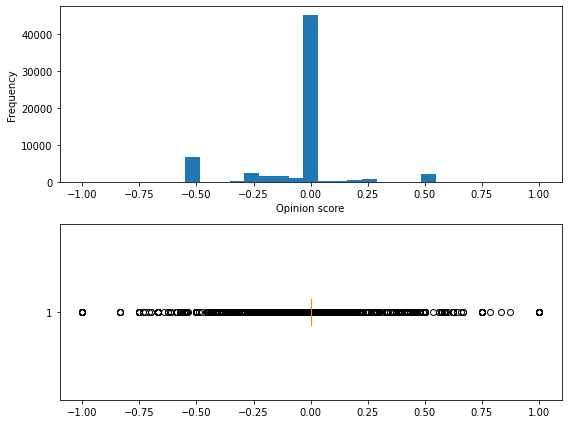

In [11]:
opinion_distribution = pd.Series(nx.get_node_attributes(ClimateGraph, 'opinion_score').values())

plt.figure(figsize=((8,6)))
ax1 = plt.subplot(211)
opinion_distribution.plot(kind='hist', bins=31)
plt.xlabel('Opinion score')

plt.subplot(212, sharex=ax1)
plt.boxplot(opinion_distribution, vert=False)

plt.tight_layout()
plt.show()

As can be seen in the figures and in the list of descriptive statistics below, the full range of the opinion score (which is between -1 and 1) is exploited, yet, the majority of authors end up with an opinion score close to 1, which originates from textual content about either News or having a neutral opinion on whether climate change is man-made or not.

In [12]:
opinion_distribution.describe()

count    64260.000000
mean        -0.050748
std          0.202097
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
dtype: float64

What is also clear is that a lot of Reddit authors do not have any awards. This finding may serve as a natural choice for selecting authority nodes in one of the research questions.

Number of Reddit authors with at least one award: 135


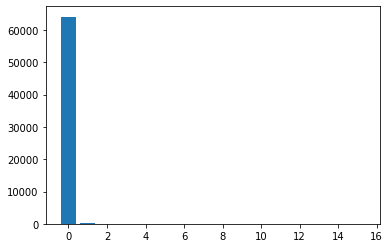

In [38]:
award_distribution = pd.Series(nx.get_node_attributes(ClimateGraph, 'total_awards_received').values())
print(f"Number of Reddit authors with at least one award: {(award_distribution > 0).sum()}")

award_distribution = Counter(award_distribution)

plt.bar(award_distribution.keys(), award_distribution.values())
plt.xlabel('Total awards received')
plt.ylabel('count')
plt.show()

In [39]:
OrderedDict(sorted(award_distribution.items(), key=lambda x: x[0]))

OrderedDict([(0, 64125),
             (1, 109),
             (2, 12),
             (3, 8),
             (4, 3),
             (6, 1),
             (7, 1),
             (15, 1)])

### 7) ClimateGraph - Network Evolution

Here the network evolution across time is investigated and plotted to see if there is a potential benefit of investigating the network structure from a temporal viewpoint.

In [6]:
temporal_ClimateGraph = pd.DataFrame([])

years = [2017, 2018, 2020]
for i, year in enumerate(tqdm(years)):
    
    ClimateGraph = read_json_file(DATA_DIR / f'{year}/ClimateGraph_{year}.json')
    opinion_dict = nx.get_node_attributes(ClimateGraph, 'opinion_score')
    
    nodes = ClimateGraph.number_of_nodes()
    edges = ClimateGraph.number_of_edges()
    
    mean_opinion = np.mean(list(opinion_dict.values()))
    var_opinion = np.std(list(opinion_dict.values()))
    
    temp = pd.DataFrame.from_dict({'nodes': [nodes],
                                   'edges': [edges],
                                   'mean_opinion': [mean_opinion],
                                   'var_opinion': [var_opinion],
                                   'year': year,
                                  })
    
    temporal_ClimateGraph = pd.concat([temporal_ClimateGraph, temp]).reset_index(drop=True)

# add sentiment label
temporal_ClimateGraph['opinion'] = temporal_ClimateGraph.mean_opinion.apply(lambda x: 'Pro' if x > 0.2 \
                                                                            else 'Anti' if x < -0.2 \
                                                                            else 'Neutral')

  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
temporal_ClimateGraph

,nodes,edges,mean_opinion,var_opinion,year,opinion
0,38415,66912,-0.054007,0.207312,2017,Neutral
1,38178,58903,-0.047296,0.212982,2018,Neutral
2,64260,95736,-0.050748,0.202096,2020,Neutral


In [ ]:
fig_temporal = px.scatter(temporal_ClimateGraph,
                 x="year", 
                 y="mean_opinion", color="opinion",
                 size='nodes', hover_data=['edges'])

fig_temporal.show()

In [ ]:
fig = make_subplots_from_px([fig_authors, fig_temporal], 'Temporal evolution in the ClimateGraph network')
fig.show()

It is further checked, whether the authors drift in opinion scores across years. This is done with respect to preceeding year (e.g. between 2017 and 2018 or between 2019 and 2020). Since preceeding year are examined, only opinion score distributions of authors occurring in both of the two considered years are compared against each other. This provides the basis for applying a paired statistical test. The choice of statistical test was based on the Shapiro-Wilks test for normality where it was found for all years, that opinion score distributions for a year do not follow a Gaussian distribution. For this reason, the non-parametrical paired test, Wilcoxon Signed Rank-Sum test (aka. Wilcoxon paired t-test) was chosen for the statistical test. The implementation is done below and the output is printed while running.

In [35]:
year = 2014
old_author = pd.read_json(DATA_DIR / f'{year}/author_opinion_{year}.json.bz2').reset_index().rename(columns={'index':'author'})

years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
for i, year in enumerate(tqdm(years)):
    print(f"\n{'-'*50} {year-1}-{year} {'-'*50}")
    year_author = pd.read_json(DATA_DIR / f'{year}/author_opinion_{year}.json.bz2').reset_index().rename(columns={'index':'author'})
    
    combined = old_author.merge(year_author, on='author', suffixes=['_old', '_new'])
    combined = combined[['author', 'opinion_score_old', 'opinion_score_new']]
    combined.sample(10)
    
    print(f"\nNumber of overlapping authors between: {combined.__len__()}\n")
    
    print(f"Shapiro-test for normality check of opinion distribution (year = {year-1}): \n{shapiro(combined['opinion_score_old'])}")
    print(f"\nShapiro-test for normality check of opinion distribution(year = {year}): \n{shapiro(combined['opinion_score_new'])}")

    wilcox = wilcoxon(combined['opinion_score_old'], combined['opinion_score_new'])
    print(f"\nWilcoxon Signed Rank-Sum Test (aka. Wilcoxon paired T-test): \n{wilcox}")
    print(f"\nRecurring authors changed their opinion between {year-1}-{year}? {wilcox.pvalue < 0.05} (95% confidence)")
    
    old_author = year_author

  0%|          | 0/8 [00:00<?, ?it/s]


-------------------------------------------------- 2014-2015 --------------------------------------------------

Number of overlapping authors between: 589

Shapiro-test for normality check of opinion distribution (year = 2014): 
ShapiroResult(statistic=0.7528210282325745, pvalue=9.552791876386761e-29)

Shapiro-test for normality check of opinion distribution(year = 2015): 
ShapiroResult(statistic=0.8626960515975952, pvalue=2.7429708465203057e-22)

Wilcoxon Signed Rank-Sum Test (aka. Wilcoxon paired T-test): 
WilcoxonResult(statistic=39052.5, pvalue=0.7773026311338965)

Recurring authors changed their opinion between 2014-2015? False (95% confidence)

-------------------------------------------------- 2015-2016 --------------------------------------------------

Number of overlapping authors between: 3066

Shapiro-test for normality check of opinion distribution (year = 2015): 
ShapiroResult(statistic=0.8170580863952637, pvalue=0.0)

Shapiro-test for normality check of opinion distrib

/Users/Olivia/Downloads/ENTER/envs/comsocsci_project/lib/python3.8/site-packages/scipy/stats/_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



Number of overlapping authors between: 9763

Shapiro-test for normality check of opinion distribution (year = 2019): 
ShapiroResult(statistic=0.8111487627029419, pvalue=0.0)

Shapiro-test for normality check of opinion distribution(year = 2020): 
ShapiroResult(statistic=0.7744287848472595, pvalue=0.0)

Wilcoxon Signed Rank-Sum Test (aka. Wilcoxon paired T-test): 
WilcoxonResult(statistic=8845423.5, pvalue=0.000609466415115974)

Recurring authors changed their opinion between 2019-2020? True (95% confidence)


/Users/Olivia/Downloads/ENTER/envs/comsocsci_project/lib/python3.8/site-packages/scipy/stats/_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



-------------------------------------------------- 2020-2021 --------------------------------------------------

Number of overlapping authors between: 7359

Shapiro-test for normality check of opinion distribution (year = 2020): 
ShapiroResult(statistic=0.7646466493606567, pvalue=0.0)

Shapiro-test for normality check of opinion distribution(year = 2021): 
ShapiroResult(statistic=0.7558145523071289, pvalue=0.0)

Wilcoxon Signed Rank-Sum Test (aka. Wilcoxon paired T-test): 
WilcoxonResult(statistic=4275292.5, pvalue=0.00037065208859555793)

Recurring authors changed their opinion between 2020-2021? True (95% confidence)

-------------------------------------------------- 2021-2022 --------------------------------------------------


/Users/Olivia/Downloads/ENTER/envs/comsocsci_project/lib/python3.8/site-packages/scipy/stats/_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



Number of overlapping authors between: 3976

Shapiro-test for normality check of opinion distribution (year = 2021): 
ShapiroResult(statistic=0.7739548087120056, pvalue=0.0)

Shapiro-test for normality check of opinion distribution(year = 2022): 
ShapiroResult(statistic=0.6837773323059082, pvalue=0.0)

Wilcoxon Signed Rank-Sum Test (aka. Wilcoxon paired T-test): 
WilcoxonResult(statistic=1153975.5, pvalue=0.5027846691416722)

Recurring authors changed their opinion between 2021-2022? False (95% confidence)
